In [1]:
import rasterio as rio
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
path = Path('../../imgs')
images = {p.name: p  for p in path.iterdir()}
path_img = [im for im in images['s2_cloudy'].iterdir()][0]
rio_cloudy = rio.open(path_img)
path_img = [im for im in images['s2'].iterdir()][0]
rio_cloudless = rio.open(path_img)

def scaled(x):
    min_val, max_val = np.percentile(x, (2, 98))

    # Scale the pixel values to the range of 0-255
    return np.interp(x, (min_val, max_val), (0, 255)).astype(np.uint8)

def sigmoid(x):
    # np.exp(-2, -3, -4) determines the bluriness
    return 255 / (1 + np.exp(-4 * (scaled(x) / 255 - 0.5)))

def get_tci(img):
    r = sigmoid(img.read(4))
    g = sigmoid(img.read(3))
    b = sigmoid(img.read(2))
    rgb = np.stack([r, g, b])
    rgb = (rgb.transpose(1, 2, 0)).astype(np.uint8)
    return rgb

cloudy = get_tci(rio_cloudy)
cloudless = get_tci(rio_cloudless)

In [3]:
def compute_contrast_score(band):
    
    # Compute the standard deviation of each band
    stds = np.std(band, axis=(0, 1))
    mean_std = np.mean(stds)
    
    # Compute the contrast score
    contrast = mean_std / np.mean(band)
    # Return the contrast score
    return contrast

def michelson_contrast(band):
    min_val, max_val, _, _ = cv2.minMaxLoc(band)
    michelson_contrast = (max_val - min_val) / (max_val + min_val)
    return michelson_contrast

def weber_contrast(band):
    """
    Solament per pixel
    """
    mean_val = np.mean(band)
    weber_contrast = (band - mean_val) / mean_val
    return weber_contrast.mean()


def rms_contrast(band):
    mean_val = np.mean(band)
    rms_contrast = np.sqrt(np.mean((band - mean_val)**2))
    return rms_contrast

def get_bands(img, correction):
    bands = [correction(img.read(b)) for b in img.indexes]
    bands = np.stack(bands)
    return bands.transpose(1,2,0)

In [4]:
rms_contrast(get_bands(rio_cloudy, lambda x:x)[:, :, 0])

130.50367122058586

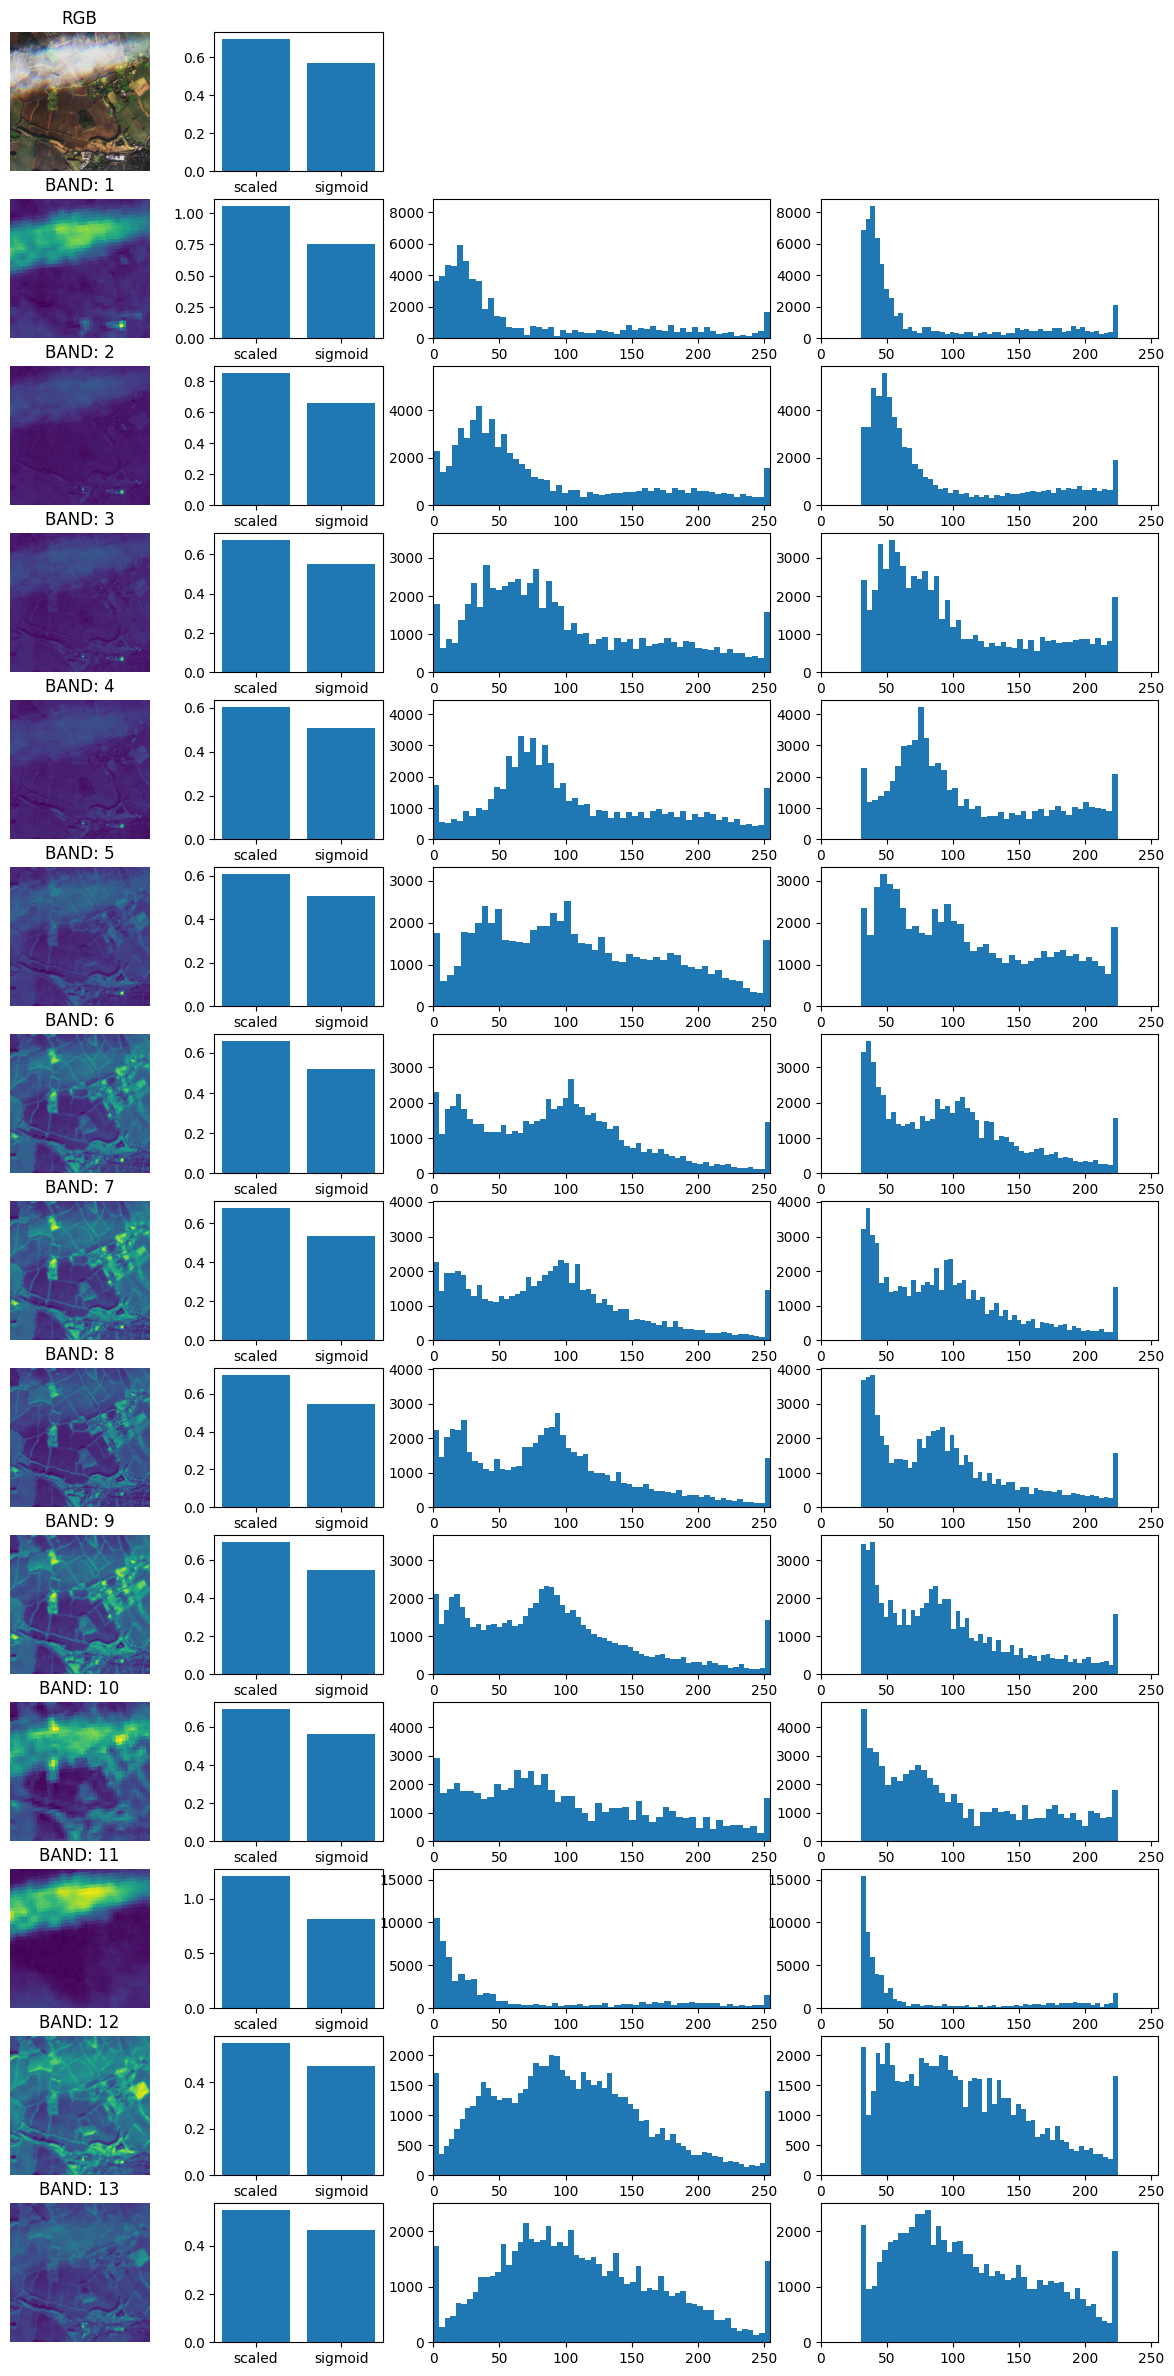

In [5]:
def plot_imshow(ax_row, band):
    ax_row[0].axis('off')
    ax_row[0].imshow(band)

def plot_blur_bar(ax_row, i, rio_img, func):
    ax_row[1].bar(['scaled', 'sigmoid'], [func(get_bands(rio_img, lambda x : scaled(x / 1000 * 255))[:, :, i]),func(get_bands(rio_img, lambda x : sigmoid(x / 1000 * 255))[:, :, i])])

def plot_line(ax_row, i, rio_img):
    img = get_bands(rio_img, lambda x:x)
    band = img[:,:,i]
    plot_imshow(ax_row, band)

def get_scaled_tci_img(img):
    r = scaled(img.read(4))
    g = scaled(img.read(3))
    b = scaled(img.read(2))
    rgb = np.stack([r, g, b])
    rgb = (rgb.transpose(1, 2, 0)).astype(np.uint8)
    return rgb

def plot_blur(rio_img, func):
    fig, axs = plt.subplots(14, 4, figsize=(15, 30), gridspec_kw={"width_ratios": (1,1, 2, 2)})
    rgb = get_tci(rio_img)
    plot_imshow(axs[0], rgb)
    gray = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
    rgb = get_scaled_tci_img(rio_img)
    gray2 = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
    axs[0][1].bar(['scaled', 'sigmoid'], [func(gray2), func(gray)])
    axs[0][0].set_title("RGB")
    axs[0][2].axis('off')
    axs[0][3].axis('off')
    for i, ax_row in enumerate(axs[1:]):
        plot_line(ax_row, i, rio_img)
        plot_blur_bar(ax_row, i, rio_img, func)
        ax_row[0].set_title("BAND: " + str(i+1))
        img = get_bands(rio_img, scaled)
        _ = ax_row[2].hist(img[:,:,i].reshape(-1), bins='auto')
        ax_row[2].set_xlim([0, 255])
        img = get_bands(rio_img, sigmoid)
        _ = ax_row[3].hist(img[:,:,i].reshape(-1), bins='auto')
        ax_row[3].set_xlim([0, 255])
        ax_row[2].sharey(ax_row[3])
plot_blur(rio_cloudy, compute_contrast_score)

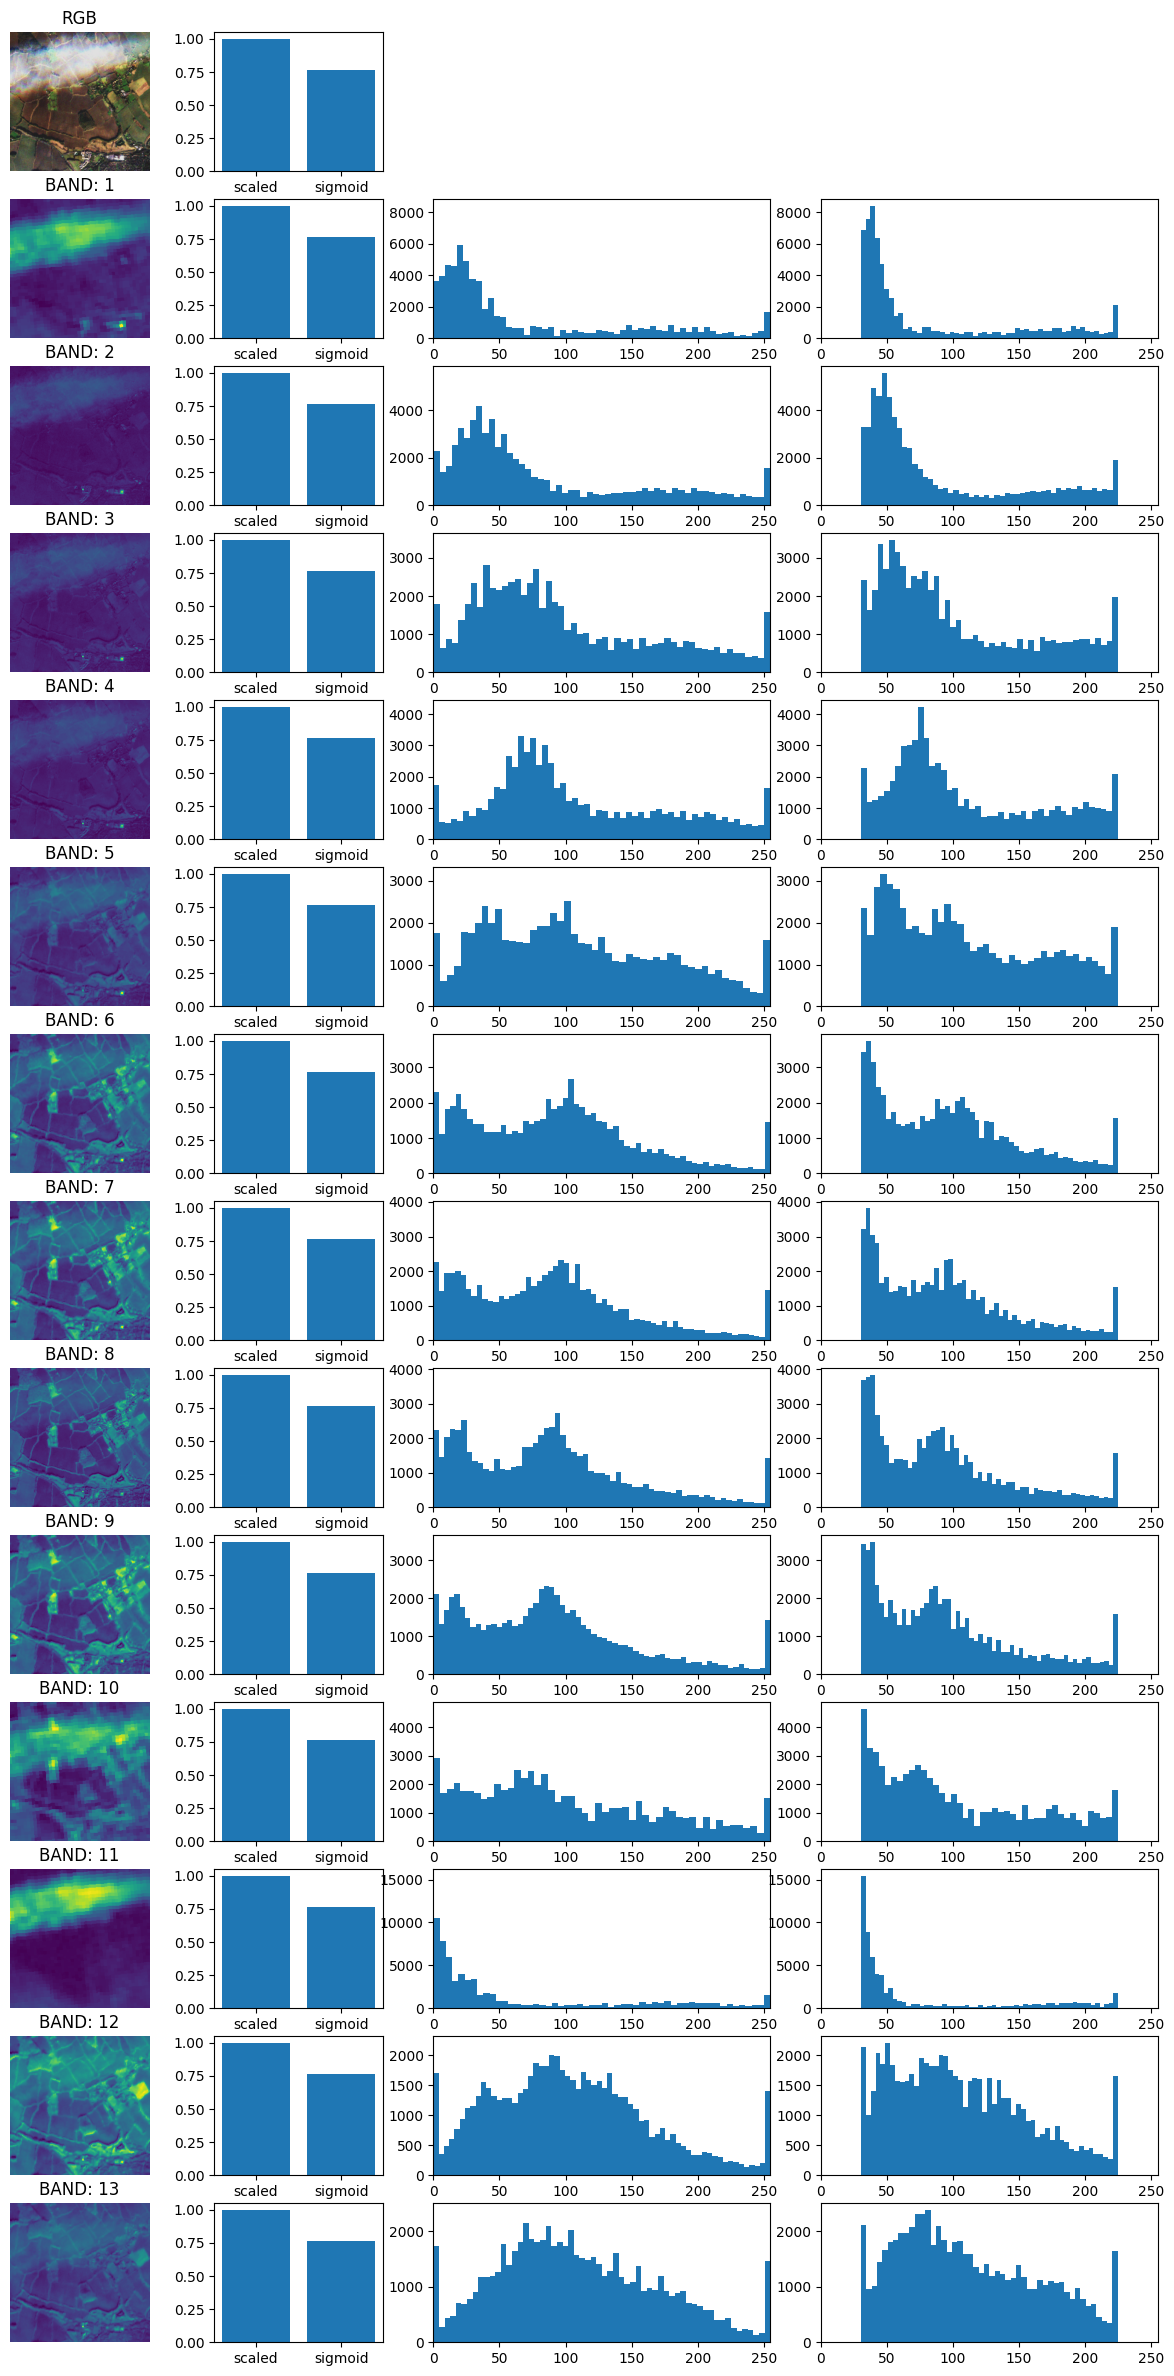

In [6]:
plot_blur(rio_cloudy, michelson_contrast)

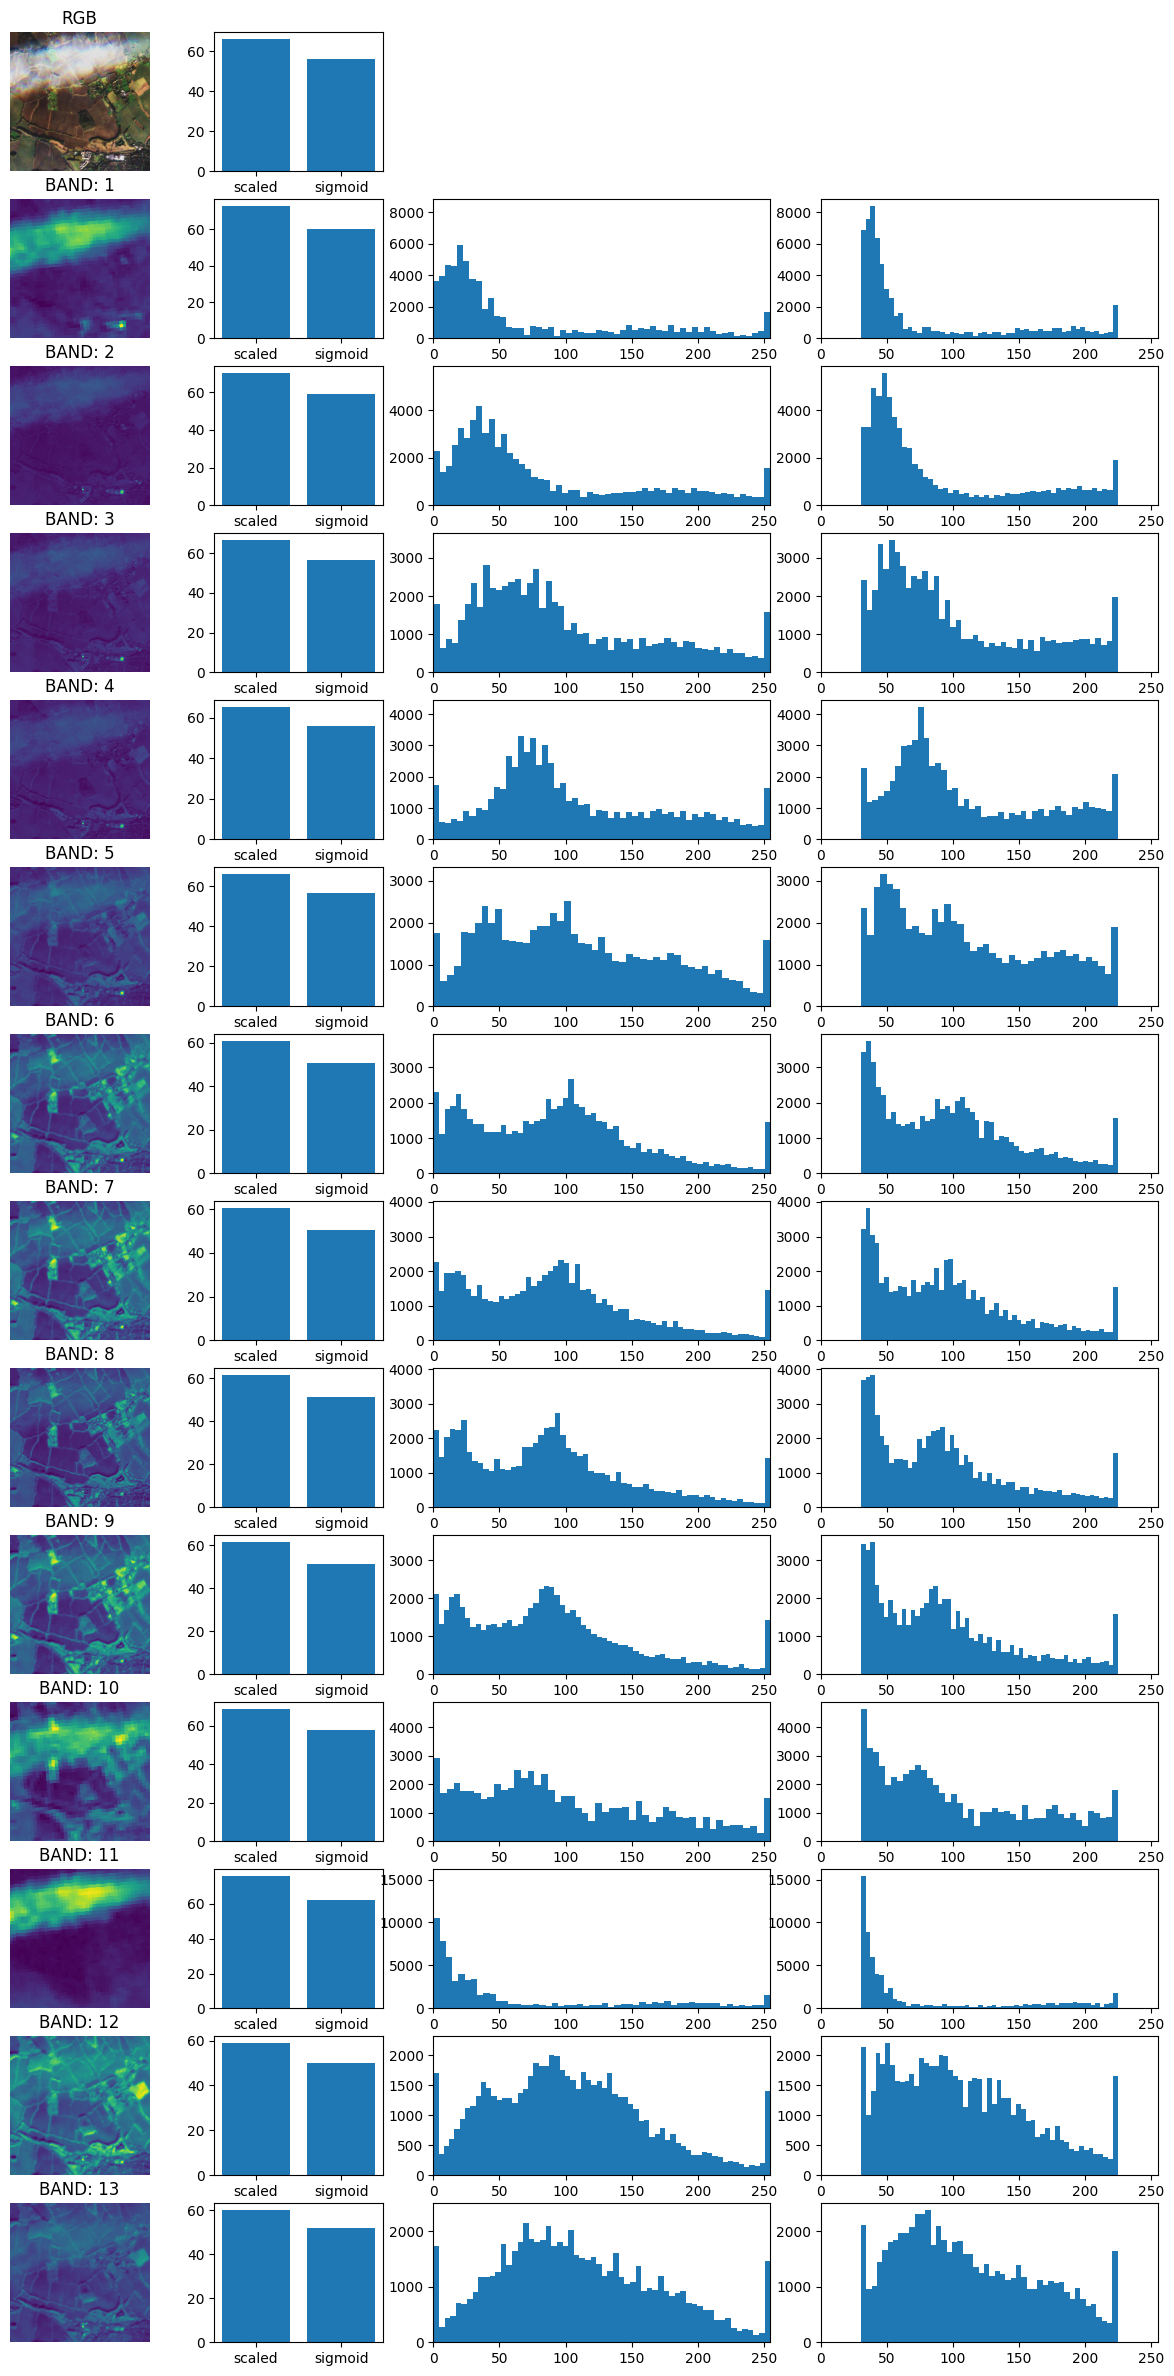

In [8]:
plot_blur(rio_cloudy, rms_contrast)

C:\Users\oriol.alas\AppData\Local\Temp\ipykernel_6508\1489696677.py:20: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[1].get_shared_y_axes().join(ax[1], ax[3])


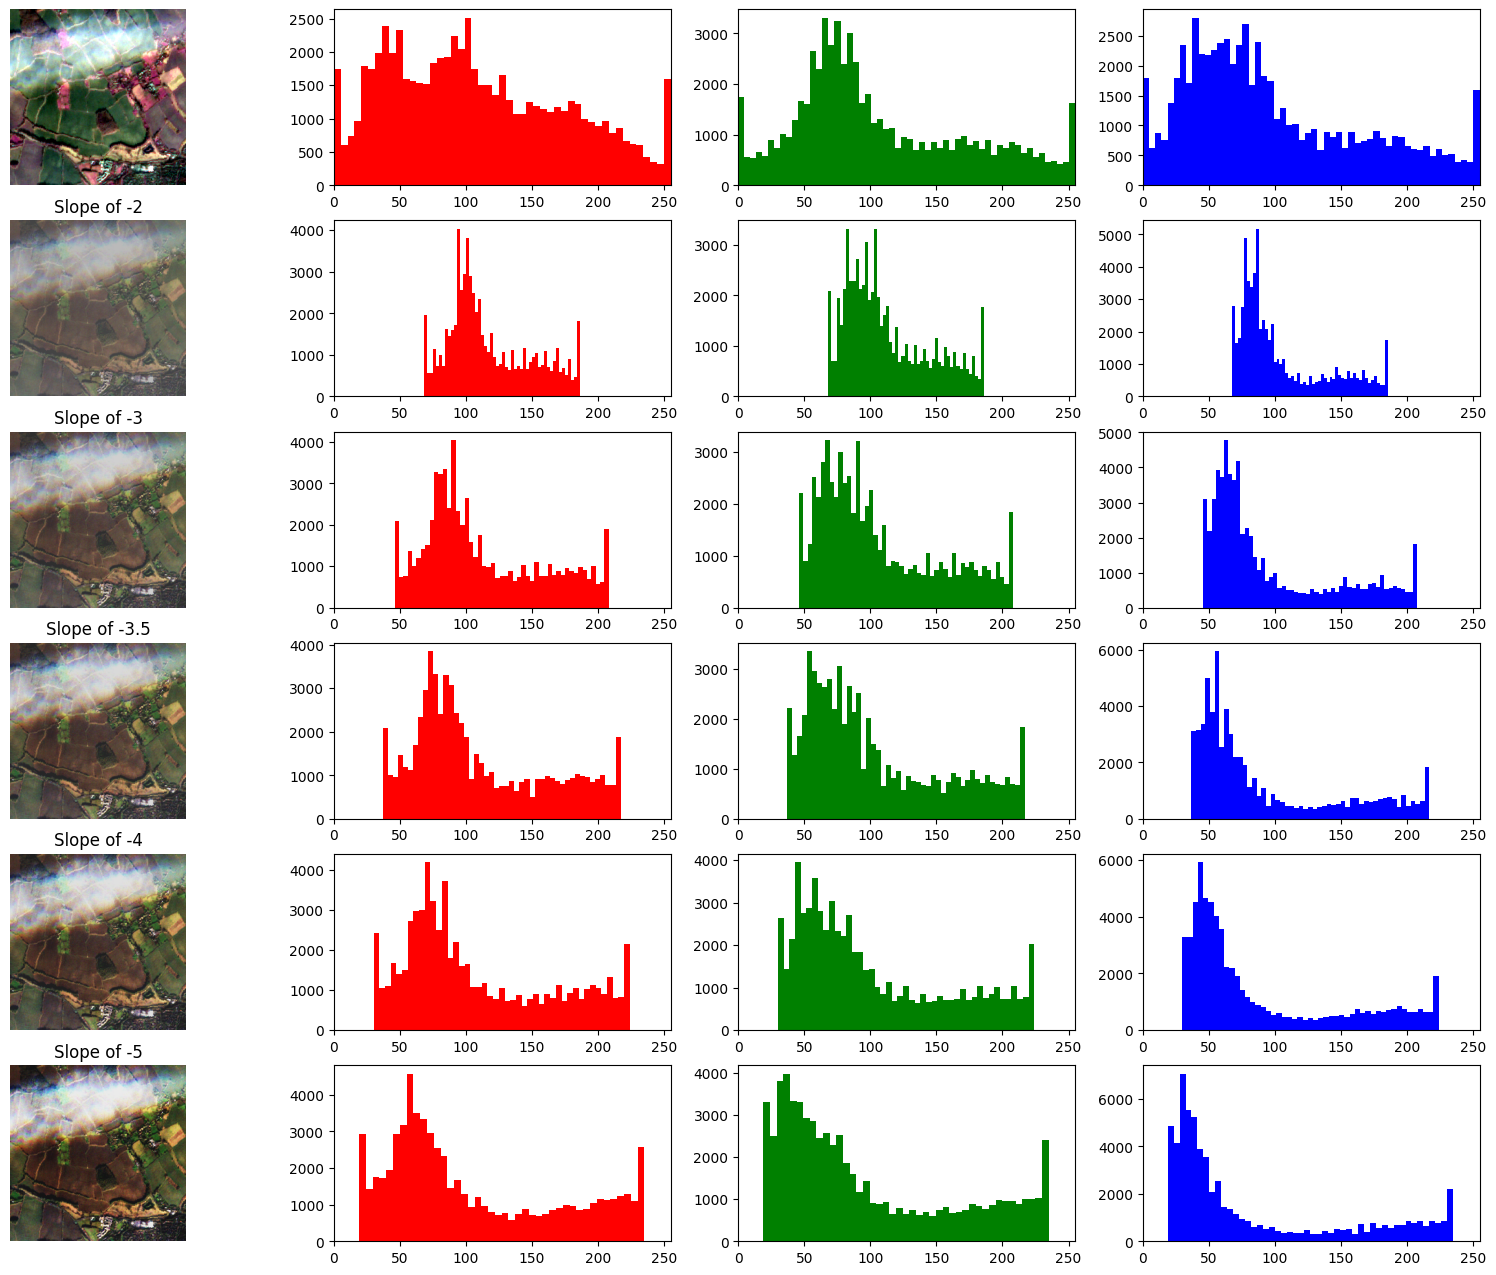

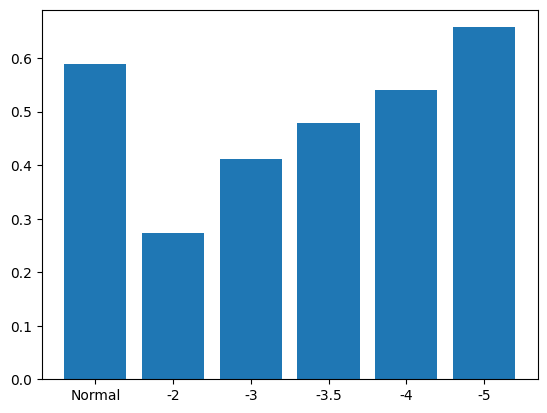

In [7]:
# plot different sigmoids to understand the proceess
from collections import defaultdict

def sigmoid_exp(x, slope, midpoint=0.5):
    return 255 / (1 + np.exp(slope * (scaled(x) / 255 - 0.5)))

def get_tci_sigmoid(rio_img, slope):
    rgb = [sigmoid_exp(rio_img.read(b), slope) for b in [4,3,2]]
    rgb = np.stack(rgb)
    rgb = (rgb.transpose(1, 2, 0)).astype(np.uint8)
    return rgb

def plot_histogram(ax, img):
    _ = ax[1].hist(img[:, :, 0].reshape(256 * 256), bins='auto', color="r")
    ax[1].set_xlim([0, 255])
    _ = ax[2].hist(img[:, :, 1].reshape(256 * 256), bins='auto', color="g")
    ax[2].set_xlim([0, 255])
    _ = ax[3].hist(img[:, :, 2].reshape(256 * 256), bins='auto', color="b")
    ax[3].set_xlim([0, 255])
    ax[1].get_shared_y_axes().join(ax[1], ax[3])

def show_differences_between_slopes(rio_cloudy):
    slopes = [-2, -3, -3.5, -4, -5]
    fig, axs = plt.subplots(len(slopes) + 1, 4, figsize=(20, 16))
    variances = defaultdict(list)
    img = get_bands(rio_cloudy, scaled)[:, :, [4,3,2]]
    axs[0][0].imshow(img)
    axs[0][0].axis('off')
    plot_histogram(axs[0], img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    variances['variance'].append(compute_contrast_score(gray))
    variances['type'].append('Normal')
    for ax, slope in zip(axs[1:], slopes):
        img = get_tci_sigmoid(rio_cloudy, slope)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        variances['variance'].append(compute_contrast_score(gray))
        variances['type'].append(f"{slope}")
        ax[0].imshow(img)
        ax[0].axis('off')
        ax[0].set_title("Slope of {}".format(slope))
        plot_histogram(ax, img)
    plt.show()
    ax = plt.subplot(111)
    ax.bar(variances['type'], variances['variance'])
show_differences_between_slopes(rio_cloudy)

In [14]:
from skimage import data, img_as_float
from skimage import exposure

In [15]:
def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r',lw=3)
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

In [52]:
img = get_tci_sigmoid(rio_cloudy, -4)

In [53]:
gamma_corrected = exposure.adjust_gamma(img, 2)
logarithmic_corrected = exposure.adjust_log(img, 1)

C:\Users\oriol.alas\AppData\Local\Temp\ipykernel_6508\562960210.py:3: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  axes = np.zeros((2, 3), dtype=np.object)
C:\Users\oriol.alas\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


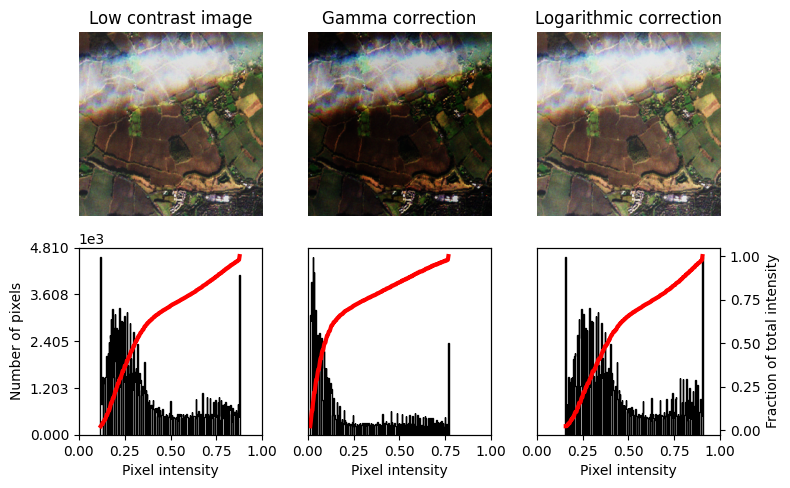

In [54]:
fig = plt.figure(figsize=(8, 5))

axes = np.zeros((2, 3), dtype=np.object)
axes[0, 0] = plt.subplot(2, 3, 1)
axes[0, 1] = plt.subplot(2, 3, 2, sharex=axes[0, 0], sharey=axes[0, 0])
axes[0, 2] = plt.subplot(2, 3, 3, sharex=axes[0, 0], sharey=axes[0, 0])
axes[1, 0] = plt.subplot(2, 3, 4)
axes[1, 1] = plt.subplot(2, 3, 5)
axes[1, 2] = plt.subplot(2, 3, 6)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(gamma_corrected, axes[:, 1])
ax_img.set_title('Gamma correction')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(logarithmic_corrected, axes[:, 2])
ax_img.set_title('Logarithmic correction')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

C:\Users\oriol.alas\AppData\Local\Temp\ipykernel_6508\3255115355.py:8: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[1].get_shared_y_axes().join(ax[2], ax[3])


{'original (s: -4)': 0.5409970866323487,
 'corrected (s: -4)': 0.45795861733982807,
 'original (s: -3)': 0.4116870135432232,
 'corrected (s: -3)': 0.34366358731108515}

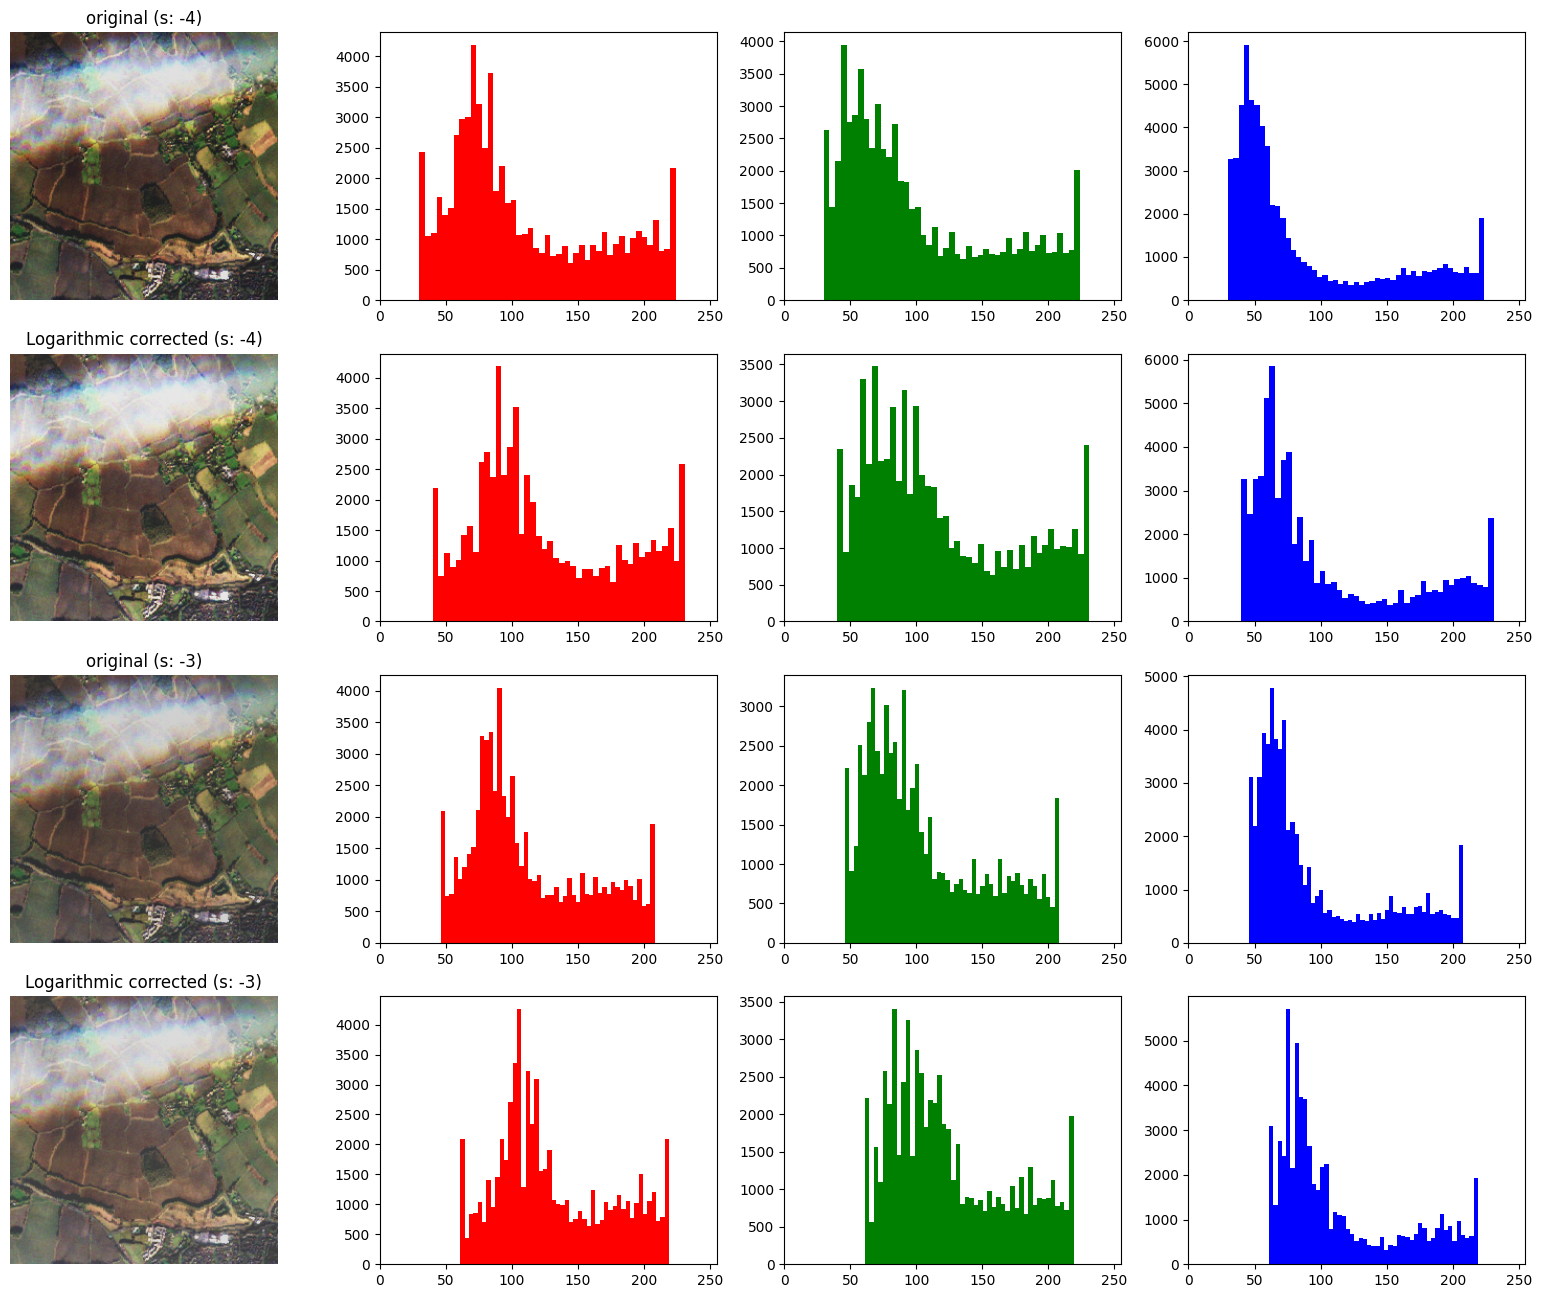

In [73]:
def plot_histogram(ax, img):
    _ = ax[1].hist(img[:, :, 0].reshape(256 * 256), bins='auto', color="r")
    ax[1].set_xlim([0, 255])
    _ = ax[2].hist(img[:, :, 1].reshape(256 * 256), bins='auto', color="g")
    ax[2].set_xlim([0, 255])
    _ = ax[3].hist(img[:, :, 2].reshape(256 * 256), bins='auto', color="b")
    ax[3].set_xlim([0, 255])
    ax[1].get_shared_y_axes().join(ax[2], ax[3])

def plot_img(img, title, ax):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(title)

def compute_rgb_contrast(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)
    return compute_contrast_score(gray)

fig, axs = plt.subplots(4, 4, figsize=(20, 4 * 4), gridspec_kw={"width_ratios": (1, 1,1,1)})
scores = dict()

plot_histogram(axs[0], img)
plot_img(img, "original (s: -4)", axs[0][0])
plot_histogram(axs[1], logarithmic_corrected)
scores['original (s: -4)'] = (compute_rgb_contrast(img))
scores['corrected (s: -4)'] = (compute_rgb_contrast(logarithmic_corrected))
plot_img(logarithmic_corrected, "Logarithmic corrected (s: -4)", axs[1][0])
img_new_slope = get_tci_sigmoid(rio_cloudy, -3)
logarithmic_corrected2 = exposure.adjust_log(img_new_slope, 1)
scores['original (s: -3)'] = (compute_rgb_contrast(img_new_slope))
plot_histogram(axs[2], img_new_slope)
plot_img(img_new_slope, "original (s: -3)", axs[2][0])

plot_histogram(axs[3], logarithmic_corrected2)
plot_img(logarithmic_corrected2, "Logarithmic corrected (s: -3)", axs[3][0])
scores['corrected (s: -3)'] = (compute_rgb_contrast(logarithmic_corrected2))

scores

<BarContainer object of 4 artists>

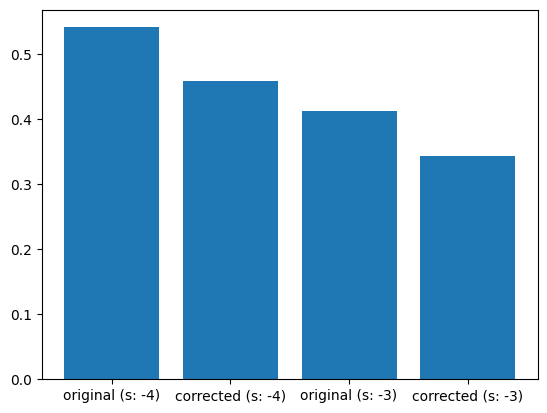

In [69]:
plt.bar(scores.keys(), scores.values())

In [61]:
list(scores.keys()), list(scores.values())

(['original (s: -4)',
  'corrected (s: -4)',
  'original (s: -3)',
  'corrected (s: -3)'],
 [[0.5409970866323487],
  [0.45795861733982807],
  [0.4116870135432232],
  [0.34366358731108515]])